# Supervised Group Project

## Data Exploration

### Data Types

In [1]:
import pandas as pd
import numpy as np
import re
from IPython.core.display import display, Markdown
pd.set_option('display.max_columns', None)

summary = pd.read_excel('Songs_2025.xlsx', sheet_name='legend')
summary = summary.rename(columns = {'year': 'Variable', 'year.1': 'Description'})

df = pd.read_excel('Songs_2025.xlsx', sheet_name='spotify songs')
summary['Data Type'] = df.dtypes.values[1:]

md_table = summary.to_markdown(index=False)
display(Markdown(md_table))
display(df.head(1))
display(Markdown('---'))

C:\Users\SLO\AppData\Local\Temp\ipykernel_21540\1906521134.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, Markdown


| Variable          | Description                                                                                                                                                                  | Data Type   |
|:------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------|
| track_name        | track name                                                                                                                                                                   | object      |
| track_popularity  | track popularity from 0 to 100                                                                                                                                               | int64       |
| album             | album the track appears on                                                                                                                                                   | object      |
| artist_name       | artist name                                                                                                                                                                  | object      |
| artist_genres     | list of the Genres the artist is associated with                                                                                                                             | object      |
| artist_popularity | artist popularity from 0 to 100, being the maximum                                                                                                                           | int64       |
| danceability      | a value of 0.0 is least danceable and 1.0 is most danceable                                                                                                                  | float64     |
| energy            | a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity, being 1.0 the maximum                                                               | float64     |
| key               | The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C,  1 = C♯/D♭,  2 = D  and so on                                              | float64     |
| loudness          | The overall loudness of a track in decibels (dB)                                                                                                                             | float64     |
| mode              | Modality (major or minor) of a track. Major = 1 and minor = 0                                                                                                                | float64     |
| speechiness       | Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. | float64     |
| acousticness      | A confidence measure from 0.0 to 1.0 of whether the track is acoustic                                                                                                        | float64     |
| instrumentalness  | Predicts whether a track contains no vocals                                                                                                                                  | float64     |
| liveness          | Detects the presence of an audience in the recording                                                                                                                         | float64     |
| valence           | a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track                                                                                            | float64     |
| tempo             | The overall estimated tempo of a track in beats per minute (BPM)                                                                                                             | float64     |
| duration_ms       | The duration of the track in milliseconds                                                                                                                                    | float64     |

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2000,7 Days,73,Born to Do It,Craig David,['british soul'],62,0.659,0.812,4.0,87.0,0.0,0.0487,0.23,0.0,0.0951,0.888,83.014,235133.0


---

### Handling Null Values

In [2]:
# Check for Missing Values
pd.DataFrame(df.isnull().sum()).rename(columns = {0:'Number_of_Nulls'})

,Number_of_Nulls
year,0
track_name,0
track_popularity,0
album,0
artist_name,0
artist_genres,0
artist_popularity,0
danceability,1
energy,1
key,1


In [3]:
# Where the missing values are coming from
missing_value = df[df.isnull().any(axis = 1)]
display(missing_value)
display(Markdown('Considering there is only one track with virtually all values missing and an average track popularity, it might make sense to just drop the value and continue with the analysis.'))

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
488,2004,These Words,68,Unwritten,Natasha Bedingfield,['dance pop'; 'pop'; 'post-teen pop'],64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Considering there is only one track with virtually all values missing and an average track popularity, it might make sense to just drop the value and continue with the analysis.

In [4]:
# Dropping the null row
df = df.drop(index = missing_value.index.item())
display(pd.DataFrame(df.isnull().sum()).rename(columns = {0:'Number_of_Nulls'}))
display(Markdown('---'))

,Number_of_Nulls
year,0
track_name,0
track_popularity,0
album,0
artist_name,0
artist_genres,0
artist_popularity,0
danceability,0
energy,0
key,0


---

### Handling Artists Genres

Two different approaches. First one takes the first value in the list of artist genres and assumes that it is the most important creating a new column called **dominant_genre_first**. 
  
`Example: ['pop', 'rock'] = pop`  
  
The second approach will split by every word and count the word that appears the most in the list. If there is an instance where it is only one genre but the genre is two words, it will take the second word and if it is only one word, will take just that word.  
  
`Example: ['pop', 'rock', 'country pop'] = pop`   
`Example: ['british soul'] = soul`  
`Example: ['country'] = country`  
  
The third approach takes a predefined list of genres that we are searching for and first tries to match whole genres to the list of predefined genres and if there are no matches then it will try individual words. If no genres are found that match the predefined list then it will return other.  
  
`list = ['hip hop', 'pop', 'rock']`

`Example: ['hip hop', 'german hip hop'] = hip hop`  
`Example: ['punk rock', 'british rock'] = rock`  
`Example: ['r&b', 'trap', 'classic'] = other`

In [5]:
# Dominant Genre based on first value in list
def extract_first_genre(genre_str):
    """
    Cleans a list in string format by removing (], [, and ') and then splits by the delimiter ';' to return the
    first value in the list of genres. (Assumes the first genre in the list is most important)
    """
    cleaned_genre = re.sub(r"[\[\]']", "", genre_str).strip()  
    genre_list = cleaned_genre.split(';')
        
    return genre_list[0].strip() 


df['dominant_genre_first'] = df['artist_genres'].apply(extract_first_genre)

In [6]:
# Dominant value based on most occuring word
def clean_and_extract_genre(genre_str):
    """
    Cleans a list in string format by removing (], [, and ') and then splits by the delimiter ';' to return a list of 
    words from the string. If the string only has one genre, it will take the second word as the dominant genre.
    If there are more words, then it will count the individual words and return the word that occurs the most.
    """
    if isinstance(genre_str, str):
        cleaned_genre = re.sub(r"[\[\]']", "", genre_str)
        genre_list = cleaned_genre.split(';')
        
        words = [word for genre in genre_list for word in genre.split()]
        
        #No words
        if not words:
            return 'Unknown'
        
        #One word
        if len(genre_list) == 1:
            return words[1] if len(words) > 1 else words[0]
        
        #Multiple words
        return max(words, key=words.count)

    return 'Unknown'

df['dominant_genre_max'] = df['artist_genres'].apply(clean_and_extract_genre)

In [7]:
# Dominant value based on a predefined word list
target_genres = {'rock', 'pop', 'hip hop', 'jazz', 'electronic', 'classical', 'blues', 
                 'country', 'metal', 'reggae', 'country pop', 'trap', 'house', 'techno'}

def extract_matching_genre(genre_str, target_genres):
    """
    First, splits the lists into individual genres and checks if it matches the predefined list. In the
    case that there are no matches, it will then split the list of genres into individual words and
    check if they match the genre list. This helps to make sure we catch genres like hip hop but also
    genres like country pop.
    """
    if isinstance(genre_str, str):
        cleaned_genre = re.sub(r"[\[\]']", "", genre_str)
        genre_list = [genre.strip().lower() for genre in cleaned_genre.split(';')]
        
        for genre in genre_list:
            if genre in target_genres:
                return genre  
        
        words = [word for genre in genre_list for word in genre.split()]
        
        if "hip" in words and "hop" in words:
            return "hip hop"
        
        for word in words:
            if word in target_genres:
                return word
        
    return 'Other' 


df['matching_genre'] = df['artist_genres'].apply(lambda x: extract_matching_genre(x, target_genres))

In [5]:
# Converting Artist popularity into a binary variable
df['artist_popularity_binary'] = df['artist_popularity'].apply(lambda x: 1 if x > 70 else 0)

In [6]:
display(df.head())
display(Markdown('---'))

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,artist_popularity_binary
0,2000,7 Days,73,Born to Do It,Craig David,['british soul'],62,0.659,0.812,4.0,87.0,0.0,0.0487,0.230000,0.0,0.0951,0.888,83.014,235133.0,0
1,2000,Absolutely (Story of a Girl) - Radio Mix,69,The Madding Crowd,Nine Days,['pop rock'],49,0.481,0.940,7.0,71.0,1.0,0.0660,0.000891,0.0,0.0939,0.660,96.493,189333.0,0
2,2000,Against All Odds (Take A Look at Me Now) - Mar...,61,Against All Odds (Take A Look at Me Now) EP,Mariah Carey,['dance pop'; 'pop'; 'urban contemporary'],76,0.542,0.498,1.0,80.0,1.0,0.0299,0.490000,0.0,0.1010,0.218,117.763,201933.0,1
3,2000,All The Small Things,84,Enema Of The State,blink-182,['alternative metal'; 'modern rock'; 'pop punk...,75,0.434,0.897,0.0,69.0,1.0,0.0488,0.010300,0.0,0.6120,0.684,148.726,167067.0,1
4,2000,Amazed,72,Lonely Grill,Lonestar,['contemporary country'; 'country'; 'country r...,57,0.561,0.543,1.0,92.0,1.0,0.0324,0.260000,0.0,0.1240,0.243,139.803,240867.0,0


---

### Unique Values

In [9]:
rows, columns = df.shape 
display(Markdown(f'''The dataset has **{rows} rows** and **{columns} columns** including the ones we created. 
                 When analyzing the unique values, we can see that our new columns for extracting the
                 dominant genre decrease the amount of unique categories that we have to work with. 
                 The number of unique values include:'''))

unique_values = pd.DataFrame(df.nunique())
unique_values = unique_values.rename(columns = {0: 'Unique Values'})
display(unique_values)
display(Markdown('---'))

The dataset has **2299 rows** and **22 columns** including the ones we created. 
                 When analyzing the unique values, we can see that our new columns for extracting the
                 dominant genre decrease the amount of unique categories that we have to work with. 
                 The number of unique values include:

,Unique Values
year,23
track_name,2120
track_popularity,71
album,1663
artist_name,891
artist_genres,698
artist_popularity,62
danceability,585
energy,641
key,12


---

### Basic Statistics

#### Map Values for Readability

In [10]:
# Convert categorical numeric columns to categorical type
df['mode'] = df['mode'].astype('category')
df['key'] = df['key'].astype('category')
df['year'] = df['year'].astype('category')
df['dominant_genre_first'] = df['dominant_genre_first'].astype('category')
df['dominant_genre_max'] = df['dominant_genre_max'].astype('category')

pitch_class_map = {
    0: "C",
    1: "C#/D♭",
    2: "D",
    3: "D#/E♭",
    4: "E",
    5: "F",
    6: "F#/G♭",
    7: "G",
    8: "G#/A♭",
    9: "A",
    10: "A#/B♭",
    11: "B"
}

mode_class_map = {
    1: 'major',
    0: 'minor'
}

df['pitch_class'] = df['key'].map(pitch_class_map).astype('category')
df['mode_class'] = df['mode'].map(mode_class_map).astype('category')

display(Markdown(df.dtypes.to_markdown()))

|                      | 0        |
|:---------------------|:---------|
| year                 | category |
| track_name           | object   |
| track_popularity     | int64    |
| album                | object   |
| artist_name          | object   |
| artist_genres        | object   |
| artist_popularity    | int64    |
| danceability         | float64  |
| energy               | float64  |
| key                  | category |
| loudness             | float64  |
| mode                 | category |
| speechiness          | float64  |
| acousticness         | float64  |
| instrumentalness     | float64  |
| liveness             | float64  |
| valence              | float64  |
| tempo                | float64  |
| duration_ms          | float64  |
| dominant_genre_first | category |
| dominant_genre_max   | category |
| matching_genre       | object   |
| pitch_class          | category |
| mode_class           | category |

#### Numeric Statistics (Mean, Median, Mode)

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
track_popularity,2299.0,70.944759,12.294047,0.000000,66.00000,72.0000,79.000000,100.000
artist_popularity,2299.0,72.873423,12.180506,29.000000,65.00000,74.0000,82.000000,100.000
danceability,2299.0,0.660116,0.141137,0.162000,0.57200,0.6710,0.759500,0.975
energy,2299.0,0.693047,0.164838,0.051900,0.58600,0.7120,0.820000,0.999
loudness,2299.0,73.006960,15.643937,-56.000000,63.00000,74.0000,83.000000,132.000
speechiness,2299.0,0.097795,0.092445,0.022500,0.03800,0.0568,0.115500,0.576
acousticness,2299.0,0.157689,0.203844,0.000013,0.01650,0.0689,0.223000,0.978
instrumentalness,2299.0,0.013766,0.083990,0.000000,0.00000,0.0000,0.000054,0.985
liveness,2299.0,0.172618,0.131620,0.021000,0.08995,0.1190,0.220000,0.843
valence,2299.0,0.535110,0.227821,0.037700,0.36050,0.5400,0.722000,0.974


In [12]:
print('Timeline:')
#print(df['year'].value_counts())

min_year = min(df['year'])
max_year = max(df['year'])
average = df['year'].value_counts().mean()

print(f'Dataset includes songs in the range {min_year}-{max_year} and is evenly split at {average} songs per year')

Timeline:
Dataset includes songs in the range 2000-2022 and is evenly split at 99.95652173913044 songs per year


In [13]:
print('Value Counts for Mode:')
print(df['mode_class'].value_counts())

Value Counts for Mode:
mode_class
major    1376
minor     923
Name: count, dtype: int64


In [14]:
print('Value Counts for Pitch:')
print(df['pitch_class'].value_counts())

Value Counts for Pitch:
pitch_class
C#/D♭    297
C        253
G        225
B        219
F        201
D        189
A        183
G#/A♭    183
F#/G♭    177
E        152
A#/B♭    147
D#/E♭     73
Name: count, dtype: int64


In [15]:
print('Top 5 Genres for Dominant Genre (First)')
print(df['dominant_genre_first'].value_counts().head(5))

Top 5 Genres for Dominant Genre (First)
dominant_genre_first
dance pop            427
pop                  256
atl hip hop           90
alternative metal     74
boy band              53
Name: count, dtype: int64


In [16]:
print('Top 5 Genres for Dominant Genre (Max)')
print(df['dominant_genre_max'].value_counts().head(5))

Top 5 Genres for Dominant Genre (Max)
dominant_genre_max
pop         943
hip         211
rap         209
rock        129
canadian     53
Name: count, dtype: int64


In [17]:
print('Top 5 Genres for (Predefined List)')
print(df['matching_genre'].value_counts().head(5))

Top 5 Genres for (Predefined List)
matching_genre
pop        1292
hip hop     363
Other       222
rock        165
trap        100
Name: count, dtype: int64


In [35]:
df.head()

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,dominant_genre_first,dominant_genre_max,matching_genre,pitch_class,mode_class,audio_cluster,cluster_standard,cluster_minmax,cluster
0,2000,7 Days,73,Born to Do It,Craig David,['british soul'],62,0.659,0.812,4.0,87.0,0.0,0.0487,0.230000,0.0,0.0951,0.888,83.014,235133.0,british soul,soul,Other,E,minor,1,1,1,2.0
1,2000,Absolutely (Story of a Girl) - Radio Mix,69,The Madding Crowd,Nine Days,['pop rock'],49,0.481,0.940,7.0,71.0,1.0,0.0660,0.000891,0.0,0.0939,0.660,96.493,189333.0,pop rock,rock,pop,G,major,2,2,2,2.0
2,2000,Against All Odds (Take A Look at Me Now) - Mar...,61,Against All Odds (Take A Look at Me Now) EP,Mariah Carey,['dance pop'; 'pop'; 'urban contemporary'],76,0.542,0.498,1.0,80.0,1.0,0.0299,0.490000,0.0,0.1010,0.218,117.763,201933.0,dance pop,pop,pop,C#/D♭,major,0,0,0,4.0
3,2000,All The Small Things,84,Enema Of The State,blink-182,['alternative metal'; 'modern rock'; 'pop punk...,75,0.434,0.897,0.0,69.0,1.0,0.0488,0.010300,0.0,0.6120,0.684,148.726,167067.0,alternative metal,punk,rock,C,major,2,2,0,0.0
4,2000,Amazed,72,Lonely Grill,Lonestar,['contemporary country'; 'country'; 'country r...,57,0.561,0.543,1.0,92.0,1.0,0.0324,0.260000,0.0,0.1240,0.243,139.803,240867.0,contemporary country,country,country,C#/D♭,major,0,0,0,4.0


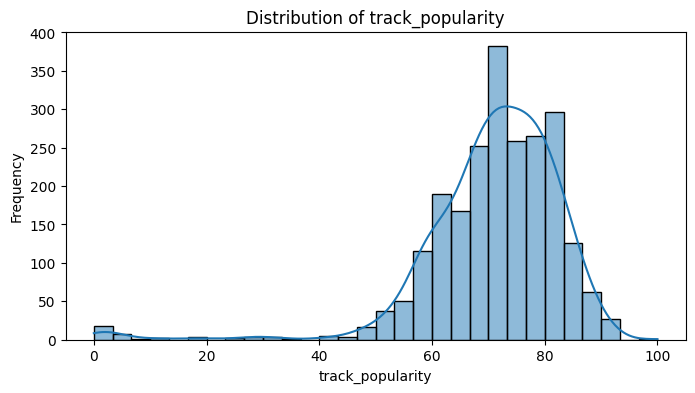

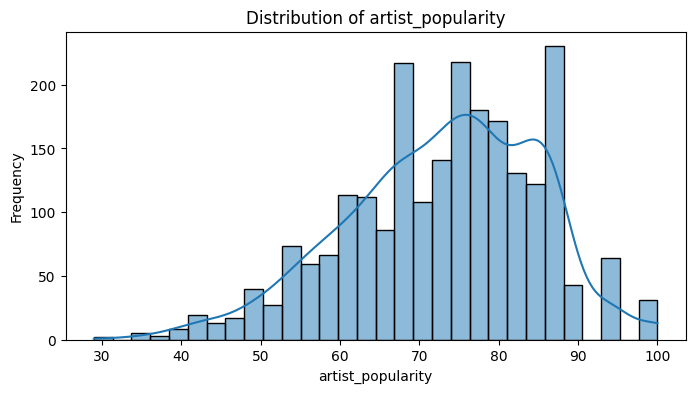

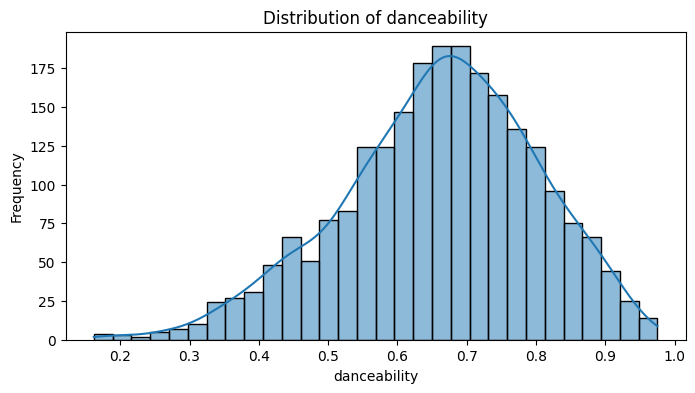

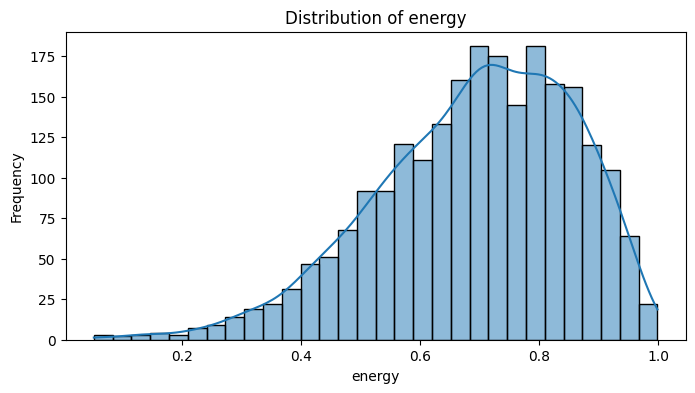

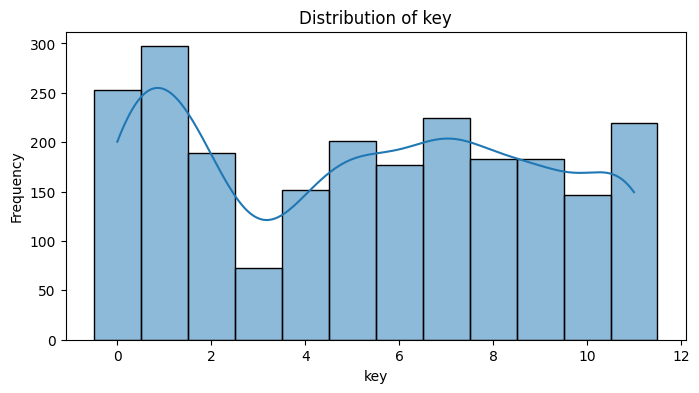

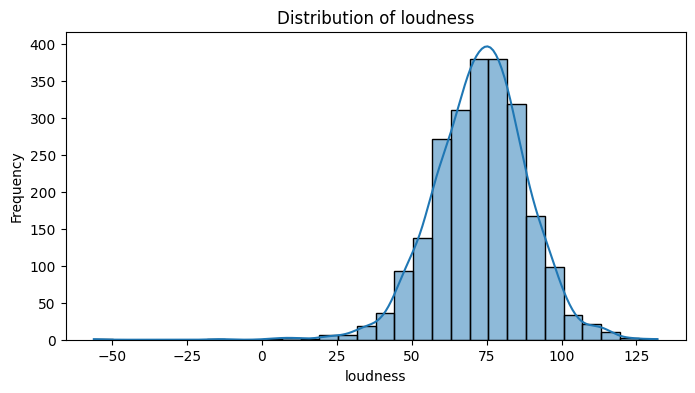

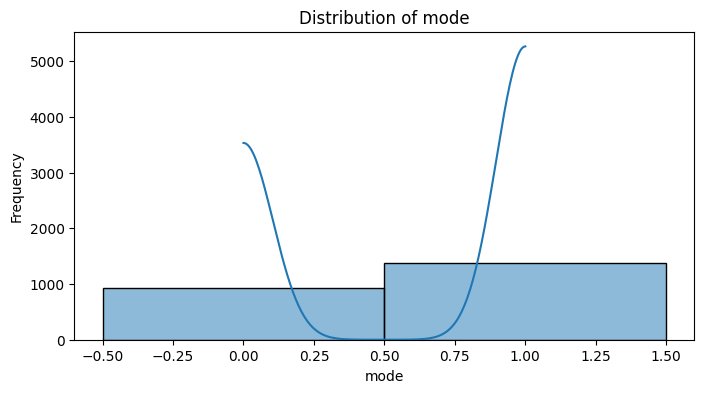

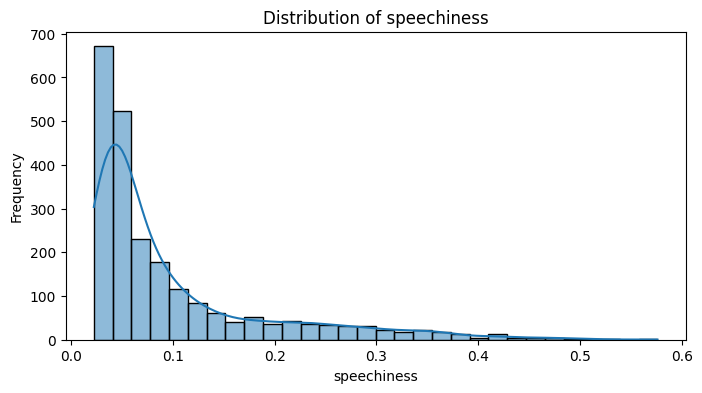

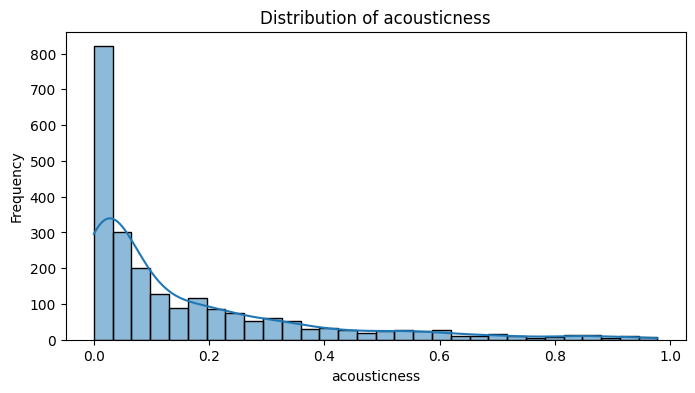

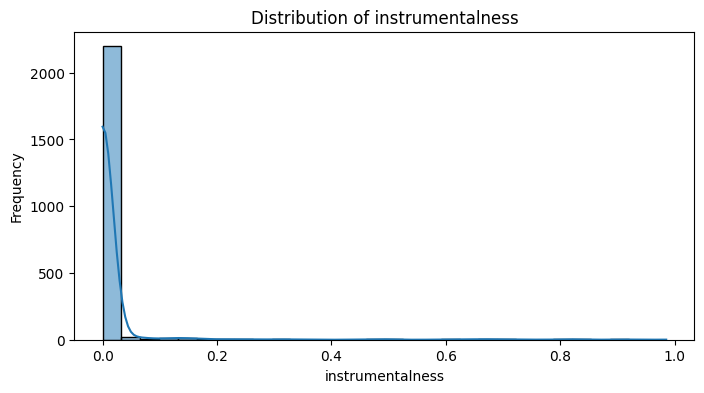

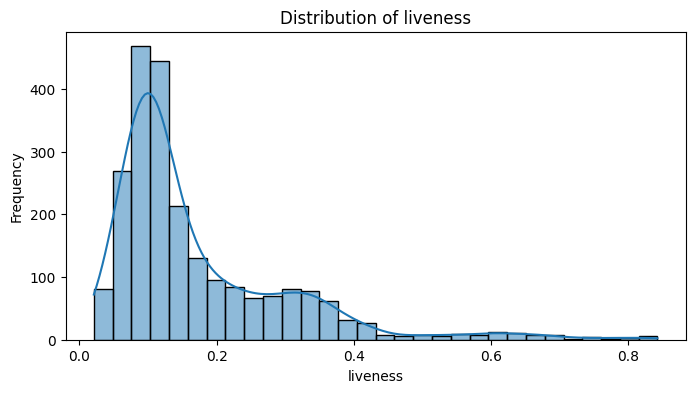

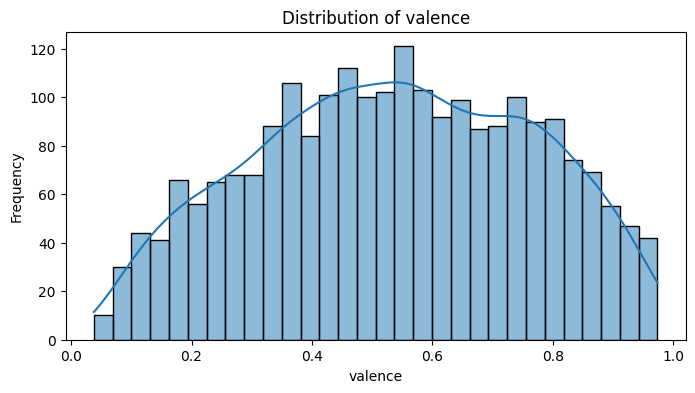

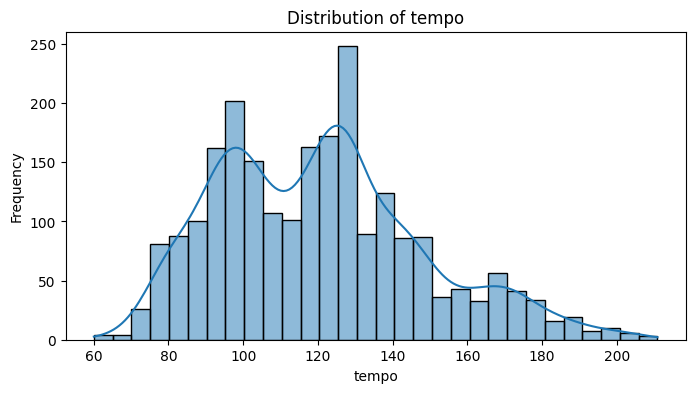

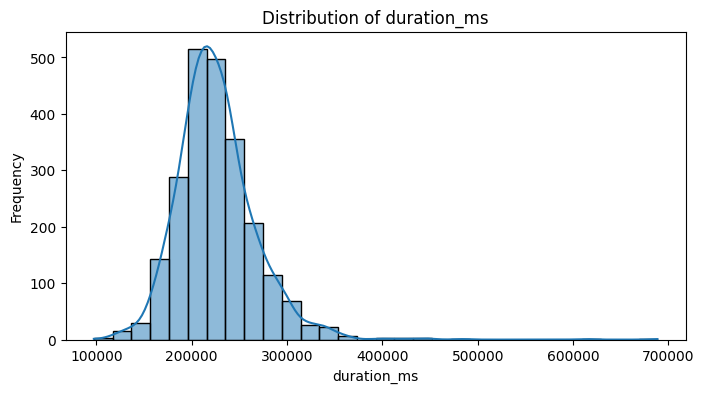

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_plot = [
    'track_popularity', 'artist_popularity', 'danceability', 'energy', 'key', 
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]

for col in columns_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True)  # KDE=True adds density curve
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

# columns_to_plot = [
#     'track_popularity', 'artist_popularity', 'danceability', 'energy', 'key', 
#     'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
#     'liveness', 'valence', 'tempo', 'duration_ms'
# ]

columns_to_plot = [
    'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]

# Loop through each column and plot
for col in columns_to_plot:
    # Compute histogram data
    hist_values, bin_edges = np.histogram(df[col], bins=30)

    # Compute KDE for smooth density line
    kde = gaussian_kde(df[col])
    x_vals = np.linspace(df[col].min(), df[col].max(), 100)

    # Scale KDE to match the histogram's max frequency
    y_vals = kde(x_vals) * len(df[col]) * (bin_edges[1] - bin_edges[0])

    # Create histogram
    fig = px.histogram(df, x=col, nbins=30, opacity=0.6, title=f'Distribution of {col}',
                       labels={col: col}, histnorm=None)

    # Add KDE line scaled to match frequency
    fig.add_trace(go.Scatter(
        x=x_vals, 
        y=y_vals, 
        mode='lines', 
        line=dict(color='red', width=2),
        name='Density Curve'
    ))

    # Show the figure
    fig.show()

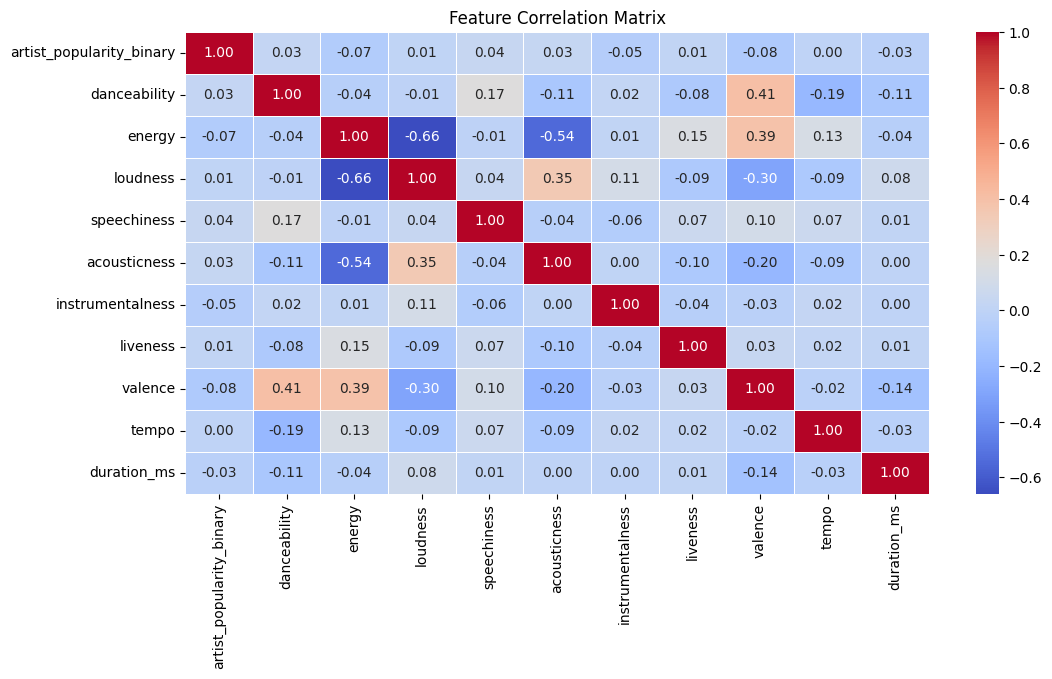

In [8]:
corr_matrix = df[columns_to_plot].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# Find highly correlated pairs
correlation_threshold = 0.3
high_corr_pairs = []

for col in corr_matrix.columns:
    for index in corr_matrix.index:
        if col != index and abs(corr_matrix.loc[col, index]) > correlation_threshold:
            high_corr_pairs.append((col, index))

# Print highly correlated features
print(f"Highly Correlated Features {correlation_threshold}:", high_corr_pairs)

Highly Correlated Features 0.05: [('artist_popularity_binary', 'energy'), ('artist_popularity_binary', 'instrumentalness'), ('artist_popularity_binary', 'valence'), ('danceability', 'speechiness'), ('danceability', 'acousticness'), ('danceability', 'liveness'), ('danceability', 'valence'), ('danceability', 'tempo'), ('danceability', 'duration_ms'), ('energy', 'artist_popularity_binary'), ('energy', 'loudness'), ('energy', 'acousticness'), ('energy', 'liveness'), ('energy', 'valence'), ('energy', 'tempo'), ('loudness', 'energy'), ('loudness', 'acousticness'), ('loudness', 'instrumentalness'), ('loudness', 'liveness'), ('loudness', 'valence'), ('loudness', 'tempo'), ('loudness', 'duration_ms'), ('speechiness', 'danceability'), ('speechiness', 'instrumentalness'), ('speechiness', 'liveness'), ('speechiness', 'valence'), ('speechiness', 'tempo'), ('acousticness', 'danceability'), ('acousticness', 'energy'), ('acousticness', 'loudness'), ('acousticness', 'liveness'), ('acousticness', 'valen

In [109]:
# features = [
#     'track_popularity', 'artist_popularity', 'danceability', 'energy', 'key', 
#     'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
#     'liveness', 'valence', 'tempo', 'duration_ms'
# ]

# dancability / valence
# artist_popularity / track_popularity
# loudness / acousticness

features = [
    'track_popularity', 'key', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]

corr_matrix = df[features].corr()
correlation_threshold = 0.3
high_corr_pairs = []

for col in corr_matrix.columns:
    for index in corr_matrix.index:
        if col != index and abs(corr_matrix.loc[col, index]) > correlation_threshold:
            high_corr_pairs.append((col, index))

# Print highly correlated features
print(f"Highly Correlated Features {correlation_threshold}:", high_corr_pairs)

Highly Correlated Features 0.3: []


## Segmentation (Groups of Similar Songs)

### Kmeans Brute Force

In [ ]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_highly_correlated_features(df_of_features, threshold):
    """
    Uses correlation matrix columns and index to find highly correlated variable pairs and returns
    a list of tuples where the correlated pair only occurs once.
    """
    corr_matrix = df_of_features.corr()
    high_corr_pairs = set()

    for col in corr_matrix.columns:
        for index in corr_matrix.index:
            if col != index and abs(corr_matrix.loc[col, index]) > threshold:
                high_corr_pairs.add(tuple(sorted((col, index))))

    return list(high_corr_pairs)

def generate_feature_combinations(features, high_corr_pairs):
    """
    Generates all valid variable sets ensuring that no correlated pair appears together.
    Also generates variable reduction subsets without testing an exponential number of combinations.
    Returns a list of lists including both generations above.
    """
    feature_sets = []

    if high_corr_pairs:
        for subset in itertools.product(*[[pair[0], pair[1]] for pair in high_corr_pairs]):
            reduced_features = set(features) - set(subset)

            is_valid = all(not (pair[0] in reduced_features and pair[1] in reduced_features) for pair in high_corr_pairs)

            if is_valid and reduced_features not in feature_sets:
                feature_sets.append(reduced_features)
    else:
        # If no correlated variables, just use the full list of variables
        feature_sets.append(set(features))

    # Feature reduction
    final_feature_sets = set()

    for feature_set in feature_sets:
        feature_list = list(feature_set)
        
        for r in range(len(feature_list) - 2, len(feature_list) + 1):  # Test near-complete sets only
            for subset in itertools.combinations(feature_list, r):
                final_feature_sets.add(subset)

    return [list(s) for s in final_feature_sets]

def run_kmeans(df, feature_sets, k_range):
    """
    Runs K-Means clustering for multiple feature sets, recording optimal k and silhouette scores.
    """
    results = []

    # Kmeans
    for features in feature_sets:
        X = df[list(features)]  # Select feature set
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Elbow Method
        inertia = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertia.append(kmeans.inertia_)

        # Optimal K from Elbow
        optimal_k = k_range[np.argmin(np.gradient(inertia))]

        # Silhouette Score
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled, labels)

        results.append({
            'features_used': list(features),
            'optimal_k': optimal_k,
            'silhouette_score': silhouette
        })

    return results

# Initial Parameters
correlation_thresholds = [0.3]  # Thresholds for correlation between variables
k_range = range(2, 11)  # Range for number of clusters to test

# Original feature list
features = [
    'track_popularity', 'artist_popularity', 'danceability', 'energy', 'key', 
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]  

final_results = []

for threshold in correlation_thresholds:
    print(f"\n🔹 Running K-Means Optimization for Correlation Threshold: {threshold}")

    # Find highly correlated variables
    high_corr_pairs = find_highly_correlated_features(df[features], threshold)

    # Generate Sets - without corr pairs and variable reduction
    feature_sets = generate_feature_combinations(features, high_corr_pairs)

    # Run K-Means
    results = run_kmeans(df, feature_sets, k_range)

    # Results
    for res in results:
        res['correlation_threshold'] = threshold
        final_results.append(res)

# Results DataFrame
df_results = pd.DataFrame(final_results)
df_results.to_csv('kmeans_results.csv')
display(Markdown(df_results.sort_values(by = ['silhouette_score'], ascending = False).head().to_markdown()))


🔹 Running K-Means Optimization for Correlation Threshold: 0.3


|     | features_used                                                                              |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|:-------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 349 | ['duration_ms', 'liveness', 'key', 'artist_popularity', 'speechiness', 'instrumentalness'] |           2 |           0.653254 |                     0.3 |
| 261 | ['duration_ms', 'liveness', 'tempo', 'key', 'track_popularity', 'instrumentalness']        |           2 |           0.652141 |                     0.3 |
| 706 | ['duration_ms', 'tempo', 'key', 'artist_popularity', 'speechiness', 'instrumentalness']    |           2 |           0.649544 |                     0.3 |
| 431 | ['duration_ms', 'liveness', 'tempo', 'key', 'artist_popularity', 'instrumentalness']       |           2 |           0.649356 |                     0.3 |
| 260 | ['liveness', 'tempo', 'key', 'artist_popularity', 'speechiness', 'instrumentalness']       |           2 |           0.645629 |                     0.3 |

In [149]:
results_csv = pd.read_csv('kmeans_results.csv')
display(Markdown(results_csv[results_csv['optimal_k'] > 2].sort_values(by=['silhouette_score'], ascending=False).head(3).to_markdown()))

|     |   Unnamed: 0 | features_used                                                                                    |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:-------------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 145 |          145 | ['liveness', 'tempo', 'mode', 'speechiness', 'track_popularity', 'instrumentalness']             |           3 |           0.288738 |                     0.3 |
| 508 |          508 | ['duration_ms', 'liveness', 'artist_popularity', 'mode', 'speechiness', 'instrumentalness']      |           3 |           0.274987 |                     0.3 |
| 702 |          702 | ['liveness', 'tempo', 'mode', 'speechiness', 'track_popularity', 'loudness', 'instrumentalness'] |           3 |           0.250953 |                     0.3 |

In [154]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

features = ['liveness', 'tempo', 'mode', 'speechiness', 'track_popularity', 'instrumentalness']

X = df[features]

# Standardize features (Z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method to find optimal k
inertia = []
K_range = range(2, 11)  # Test k from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Choose optimal k from the elbow method
optimal_k = 3  # Change this based on the elbow method result

# Run K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

from sklearn.metrics import silhouette_score

# Compute Silhouette Score
silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# Reduce dimensions using PCA (to visualize in 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA output to DataFrame
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = df['audio_cluster']  # Assign cluster labels

# Add feature columns to df_pca for hover data
for col in features:
    df_pca[col] = df[col].values  # Copy feature values from original df

# Create an interactive scatter plot with Plotly
fig = px.scatter(df_pca, 
                 x='PCA1', 
                 y='PCA2', 
                 color=df_pca['Cluster'].astype(str),  # Convert cluster to string for categorical coloring
                 title=f"K-Means Clusters (k={optimal_k}) - PCA Projection",
                 labels={'Cluster': 'Cluster'},
                 color_discrete_sequence=px.colors.qualitative.Set1,  # Use a nice color set
                 hover_data=features,
                 template = 'plotly_dark')  # Now it correctly references features from df_pca

# Show the plot
fig.show()

Silhouette Score for K=3: 0.289


### DBSCAN

EDA / Segmentation (14)

Predictive Model / Model Evaluation (19)

Report (22)

# Backup

In [ ]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_highly_correlated_features(df_of_features, threshold):
    """
    Iterates through a correlataion matrix of a dataframe including the specified variables and checks for variables
    that are highly correlated and returns a tuple of both combinations of the variables.
    """
    corr_matrix = df_of_features.corr()
    high_corr_pairs = set()

    for col in corr_matrix.columns:
        for index in corr_matrix.index:
            if col != index and abs(corr_matrix.loc[col, index]) > threshold:
                high_corr_pairs.add(tuple(sorted((col, index))))

    return list(high_corr_pairs)

def generate_feature_combinations(features, high_corr_pairs):
    """
    Generate all valid feature sets ensuring that no correlated pair appears together,
    while also avoiding duplicate sets.
    """
    import itertools

    feature_sets = []

    # Generate combinations by removing one feature from each correlated pair
    for subset in itertools.product(*[[pair[0], pair[1]] for pair in high_corr_pairs]):
        reduced_features = set(features) - set(subset)

        # Ensure that no correlated pairs exist in the feature set
        is_valid = all(not (pair[0] in reduced_features and pair[1] in reduced_features) for pair in high_corr_pairs)

        # Avoid duplicate sets
        if is_valid and reduced_features not in feature_sets:
            feature_sets.append(reduced_features)

    return [list(s) for s in feature_sets]  # Convert sets to lists for consistency


def run_kmeans(df, feature_sets, k_range):
    """
    Run K-Means clustering for multiple feature sets, recording optimal k and silhouette scores.
    """
    results = []

    for features in feature_sets:
        X = df[list(features)]  # Select feature set
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Find optimal k using the Elbow Method
        inertia = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertia.append(kmeans.inertia_)

        # Determine the elbow point (optimal k)
        optimal_k = k_range[np.argmin(np.gradient(inertia))]

        # Compute Silhouette Score for optimal k
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled, labels)

        # Save results
        results.append({
            'features_used': list(features),
            'optimal_k': optimal_k,
            'silhouette_score': silhouette
        })

    return results

# 📌 Define parameters
correlation_thresholds = [0.3, 0.5, 0.7]  # Test different thresholds
k_range = range(2, 11)  # Range for K-Means
features = [
    'track_popularity', 'artist_popularity', 'danceability', 'energy', 'key', 
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]  # Original feature list

# Store all results
final_results = []

# 📌 Run the full process for each correlation threshold
for threshold in correlation_thresholds:
    print(f"\n🔹 Running K-Means Optimization for Correlation Threshold: {threshold}")

    # Find highly correlated feature pairs
    high_corr_pairs = find_highly_correlated_features(df[features], threshold)

    if not high_corr_pairs:
        print(f"No highly correlated features found at threshold {threshold}. Using all features.")
        feature_sets = [set(features)]
    else:
        feature_sets = generate_feature_combinations(features, high_corr_pairs)

    # Run K-Means with these feature sets
    results = run_kmeans(df, feature_sets, k_range)

    # Store results
    for res in results:
        res['correlation_threshold'] = threshold
        final_results.append(res)

# 📌 Convert results to DataFrame for documentation
df_results = pd.DataFrame(final_results)

# 📌 Display results sorted by best Silhouette Score
df_results = df_results.sort_values(by='silhouette_score', ascending=False)
display(Markdown(df_results.to_markdown()))